In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import struct
from datetime import time
ticks_per_sec = 10000

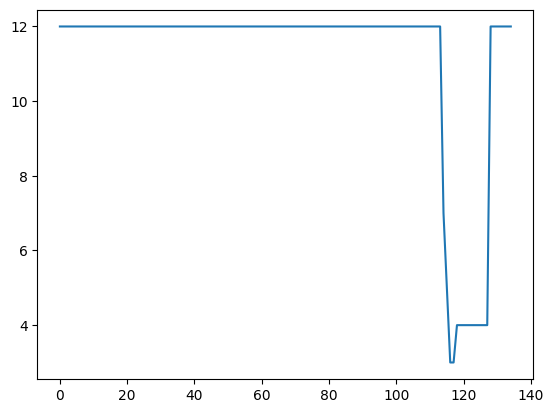

In [2]:
horusdf = pd.read_csv('/home/unknown/Backyard Flight/horus.csv')['satellites'].plot()

In [3]:
with open('/home/unknown/Backyard Flight/fast.cap') as f:
    fastlines = f.readlines()
fast_bytes = bytearray()
for i, line in enumerate(fastlines):
    try:
        fast_bytes.extend(bytearray.fromhex(line))
    except:
        print(i)

In [4]:
fast_pacs = struct.iter_unpack('qffffffffffffffffffffffffffffffffffffffffffffffffffffffffffffff', fast_bytes)

def modify_pacs(pac):
    inner = []
    gyro_start = 3
    acc_start = 33
    for i in range(10):
        l = [pac[0] if i == 0 else None, pac[1], pac[2], pac[gyro_start], pac[gyro_start+1],pac[gyro_start+2], pac[acc_start], pac[acc_start+1],pac[acc_start+2]]
        gyro_start+=3
        acc_start+=3
        inner.append(l)
    return inner


fast_pacs = sorted(fast_pacs, key = lambda l : l[0])

fast_parts = [small for pac in fast_pacs for small in modify_pacs(pac) ]
fastdf = pd.DataFrame(fast_parts, columns=['timestamp', 'press', 'temp', 'gx', 'gy', 'gz', 'ax', 'ay', 'az'])

fastdf = fastdf[fastdf.timestamp!=-1].dropna(how='all').interpolate()
fastdf.timestamp = fastdf.timestamp/ticks_per_sec

<Axes: xlabel='timestamp'>

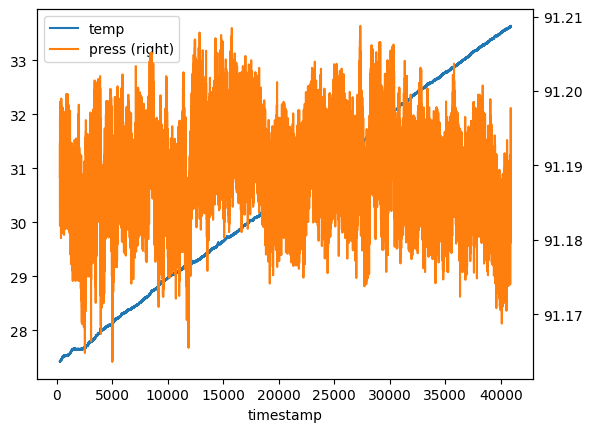

In [5]:
fastdf[['timestamp','temp','press']].plot(x='timestamp', secondary_y='press')

In [69]:

with open('/home/unknown/rangetest.cap') as f:
    slowlines = f.readlines()[12:-4]
slow_bytes = bytearray()
for line in slowlines:
    slow_bytes.extend(bytearray.fromhex(line))

In [ ]:
slowlines = slowlines[:30000]


In [ ]:
slowdf

TypeError: '_struct.unpack_iterator' object is not subscriptable

In [97]:
slow_pacs = struct.iter_unpack('<qQhhbbbBBBHHBB', slow_bytes)
slowdf = pd.DataFrame.from_records(slow_pacs, columns=['timestamp', 'packed', 'latfrac', 'lonfrac', 'ox', 'oy', 'oz', 'flight_state', 'o2', 'o3', 'voltage', 'current', 'temp', 'flip_status'])

slowdf = slowdf.iloc[:611]

voltage_base = 6.75; # 6.75 to 9.25
voltage_scale = 100; # 2.5 volt range to 250 volt range
lat_int = 31
long_int = -102

slowdf.ox = slowdf.ox.map(lambda i8 : i8/127)
slowdf.oy = slowdf.oy.map(lambda i8 : i8/127)
slowdf.oz = slowdf.oz.map(lambda i8 : i8/127)


slowdf.voltage = (slowdf.voltage / voltage_scale) + voltage_base

slowdf.timestamp = slowdf.timestamp/100
# slowdf.timestamp = slowdf.timestamp/ticks_per_sec

flight_state_to_str = ['NotSet', 'OnPad', 'Boost', 'Flight', 'InitialRoll', 'InitialPump', 'Continous']
slowdf.flight_state = slowdf.flight_state.map(lambda fs : flight_state_to_str[int(fs)])

In [94]:
MILLIS_LOC, MILLIS_MASK = 1, 0b111111111111111111111111111
SATS_LOC, SATS_MASK = 28, 0b1111

def unpack_gps(u64):
    u64 = int(u64)
    as_millis = (u64 >> MILLIS_LOC) & MILLIS_MASK
    ms = as_millis % 1000
    as_sec = as_millis // 1000
    sec = as_sec % 60
    as_min = as_sec // 60
    min = as_min % 60
    hr = as_min // 60

    sats = (u64 >> SATS_LOC) & SATS_MASK

    t = time(hr, min, sec)

    return t, as_sec, sats

In [114]:
slowdf[['time', 'sec', 'sats']] = slowdf.apply(lambda r : unpack_gps(r.packed), axis=1, result_type='expand')

In [136]:
slowdf

,timestamp,packed,latfrac,lonfrac,ox,oy,oz,flight_state,o2,o3,voltage,current,temp,flip_status,time,sec,sats
0,653.78,3256102611274279408,-1418,10818,0.181102,-0.976378,0.086614,OnPad,114,165,8.16,0,35,255,21:29:47,77387,12
1,754.72,3254976711367438784,-1418,10818,0.031496,-0.992126,0.007874,OnPad,122,152,8.16,0,35,255,21:29:48,77388,12
2,856.30,3254976711367440784,-1418,10817,0.023622,-0.992126,0.007874,OnPad,10,165,8.16,0,35,255,21:29:49,77389,12
3,957.05,3254976711367442784,-1418,10817,0.031496,-0.992126,0.007874,OnPad,14,227,8.16,0,35,255,21:29:50,77390,12
4,1058.68,3253850811460602160,-1418,10817,0.023622,-0.992126,0.015748,OnPad,80,115,8.16,0,35,255,21:29:51,77391,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,61213.60,3238088212765993424,-1419,10819,-0.031496,-0.992126,0.000000,Continous,122,98,8.15,0,37,255,21:39:45,77985,12
607,61315.22,3238088212765995424,-1419,10819,-0.031496,-0.992126,0.000000,Continous,146,63,8.15,0,37,255,21:39:46,77986,12
608,61416.27,3238088212765997424,-1419,10818,-0.031496,-0.992126,0.000000,Continous,114,165,8.15,0,37,255,21:39:47,77987,12
609,61517.92,3238088212765999424,-1419,10818,-0.031496,-0.992126,0.000000,Continous,122,152,8.15,0,37,255,21:39:48,77988,12


<Axes: >

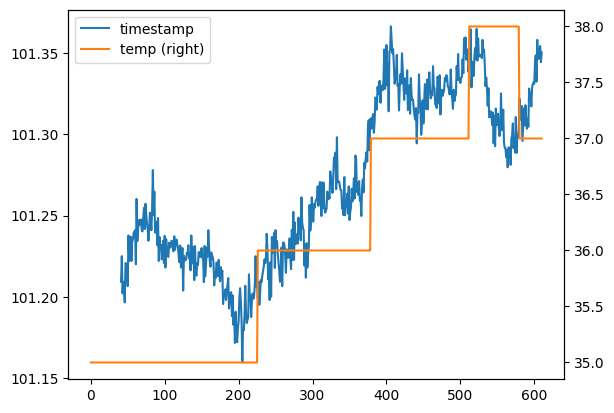

In [ ]:
snodupe = slowdf.drop_duplicates('sec')

ax = snodupe[['timestamp']].diff().rolling(40).mean()..plot()
snodupe[['temp']].plot(ax=ax, secondary_y=True)

<Axes: >

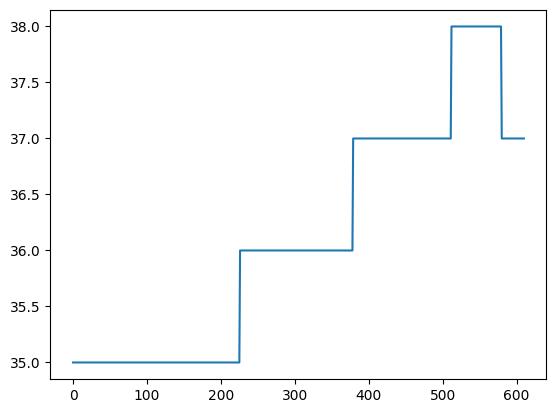

In [121]:
slowdf['temp'].plot()